# Data ETL Process

### This notebook reads the data from two data libraries: a) one with the full transaction history of al Crypto Punk ETFs, and b) another library of image files (.png) for each individual Crypto Punk. 

### The ETL process creates __ tables for the project:

### * crypto_punks_df (Pandas dataframe)
### * accessories_df (Pandas dataframe)
### * crypto_punks_mdb (MongoDB database)
### * crypto_punks_col (Mongo DB collection)

#### Please refer to the project ERD for details on the data tables and structures.

In [1]:
# Import Dependencies

import os
import sqlite3
import requests
import json

# Import MongoDB libraries for database management 
import pymongo
from pymongo import MongoClient

# Import data manipulation libraries
import numpy as np
import pandas as pd
import random

# Import machine learning libraries
from scipy.optimize import curve_fit
from scipy.special import zeta

# Import image and plotting libraries
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap


## Read the Data File

In [2]:
# Read the trading data json file
df = pd.read_json("Data/txn_history-2021-10-07.jsonl", lines=True)
df.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


In [3]:
# Inspect the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167492 entries, 0 to 167491
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   txn_type             167492 non-null  object        
 1   from                 167492 non-null  object        
 2   to                   167492 non-null  object        
 3   date                 167492 non-null  datetime64[ns]
 4   timestamp            167492 non-null  datetime64[ns]
 5   source               167492 non-null  object        
 6   eth                  127542 non-null  float64       
 7   punk_id              167492 non-null  int64         
 8   from_wallet_address  419 non-null     object        
 9   to_wallet_address    419 non-null     object        
 10  type                 167492 non-null  object        
 11  accessories          167492 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(8)
memory usage: 15.3

In [4]:
# Fill "nan" values in the "eth" column with zeroes.
df["eth"] = df["eth"].fillna(0)
df.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


## Create a Data Table For the Unique Punk IDs and Relevant Features (Type, Accessories)

In [5]:
# Create a copy of the dataframe with only unique values for punk_id
# and the columns describing the characteristics of each individual
# Crypto_punk nft. 
temp_df = df
temp_df = temp_df.drop(columns=['txn_type', 'from', 'to', 'date', 'timestamp', 'source', 'eth', 'from_wallet_address', 'to_wallet_address'])

# Convert the 'type' object to string
temp_df['type'] = temp_df['type'].astype('str')
temp_df['accessories'] = temp_df['accessories'].astype('str')

# Remove the brackets from the 'type'
for row in range(len(temp_df)):
    
    type = temp_df.at[row,'type']
    # index each string to exclude the first two and last two 
    # characters (brackets and quotes)
    clean_type = type[2:-2]
    temp_df.at[row,'type'] = clean_type
    
    #accessories = temp_df.at[row,'accessories']
    #clean_accessories = accessories[2:-2]
    #print(clean_accessories)
    #temp_df.at[row,'accessories'] = clean_accessories

crypto_punks_df = temp_df.drop_duplicates()
crypto_punks_df

,punk_id,type,accessories
0,0,Female,"['Green Eye Shadow', 'Earring', 'Blonde Bob']"
41,1,Male,"['Smile', 'Mohawk']"
104,2,Female,['Wild Hair']
134,3,Male,"['Wild Hair', 'Nerd Glasses', 'Pipe']"
151,4,Male,"['Big Shades', 'Wild Hair', 'Earring', 'Goat']"
...,...,...,...
167357,9995,Female,"['Purple Eye Shadow', 'Straight Hair Dark']"
167364,9996,Male,"['Cigarette', 'Earring', 'Crazy Hair', 'Smile']"
167369,9997,Zombie,"['Front Beard', 'Cap Forward']"
167412,9998,Female,"['Wild White Hair', 'Black Lipstick', 'Clown E..."


In [6]:
# Reset the index to the same dataframe without adding a new column 
# for the old index information
crypto_punks_df.reset_index(drop=True, inplace=True)
crypto_punks_df

,punk_id,type,accessories
0,0,Female,"['Green Eye Shadow', 'Earring', 'Blonde Bob']"
1,1,Male,"['Smile', 'Mohawk']"
2,2,Female,['Wild Hair']
3,3,Male,"['Wild Hair', 'Nerd Glasses', 'Pipe']"
4,4,Male,"['Big Shades', 'Wild Hair', 'Earring', 'Goat']"
...,...,...,...
9995,9995,Female,"['Purple Eye Shadow', 'Straight Hair Dark']"
9996,9996,Male,"['Cigarette', 'Earring', 'Crazy Hair', 'Smile']"
9997,9997,Zombie,"['Front Beard', 'Cap Forward']"
9998,9998,Female,"['Wild White Hair', 'Black Lipstick', 'Clown E..."


In [7]:
# Inspect the data types
crypto_punks_df.dtypes

punk_id         int64
type           object
accessories    object
dtype: object

In [8]:
# Change the punk_id data type from numpy int64 to object
# so that PyMongo can process later.
crypto_punks_df["punk_id"]=crypto_punks_df["punk_id"].astype(object)
crypto_punks_df

/var/folders/lc/bd2hdpn53fnd_gtfy8gt049h0000gn/T/ipykernel_21668/294866334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crypto_punks_df["punk_id"]=crypto_punks_df["punk_id"].astype(object)


,punk_id,type,accessories
0,0,Female,"['Green Eye Shadow', 'Earring', 'Blonde Bob']"
1,1,Male,"['Smile', 'Mohawk']"
2,2,Female,['Wild Hair']
3,3,Male,"['Wild Hair', 'Nerd Glasses', 'Pipe']"
4,4,Male,"['Big Shades', 'Wild Hair', 'Earring', 'Goat']"
...,...,...,...
9995,9995,Female,"['Purple Eye Shadow', 'Straight Hair Dark']"
9996,9996,Male,"['Cigarette', 'Earring', 'Crazy Hair', 'Smile']"
9997,9997,Zombie,"['Front Beard', 'Cap Forward']"
9998,9998,Female,"['Wild White Hair', 'Black Lipstick', 'Clown E..."


In [9]:
# Re-inspect the data types
crypto_punks_df.dtypes

punk_id        object
type           object
accessories    object
dtype: object

In [10]:
# Get a count of the unique Crypto Punk NFT type
print(crypto_punks_df['type'].value_counts())

Male      6039
Female    3840
Zombie      88
Ape         24
Alien        9
Name: type, dtype: int64


## Inspect a Sample of the Image Files

<function matplotlib.pyplot.show(close=None, block=None)>

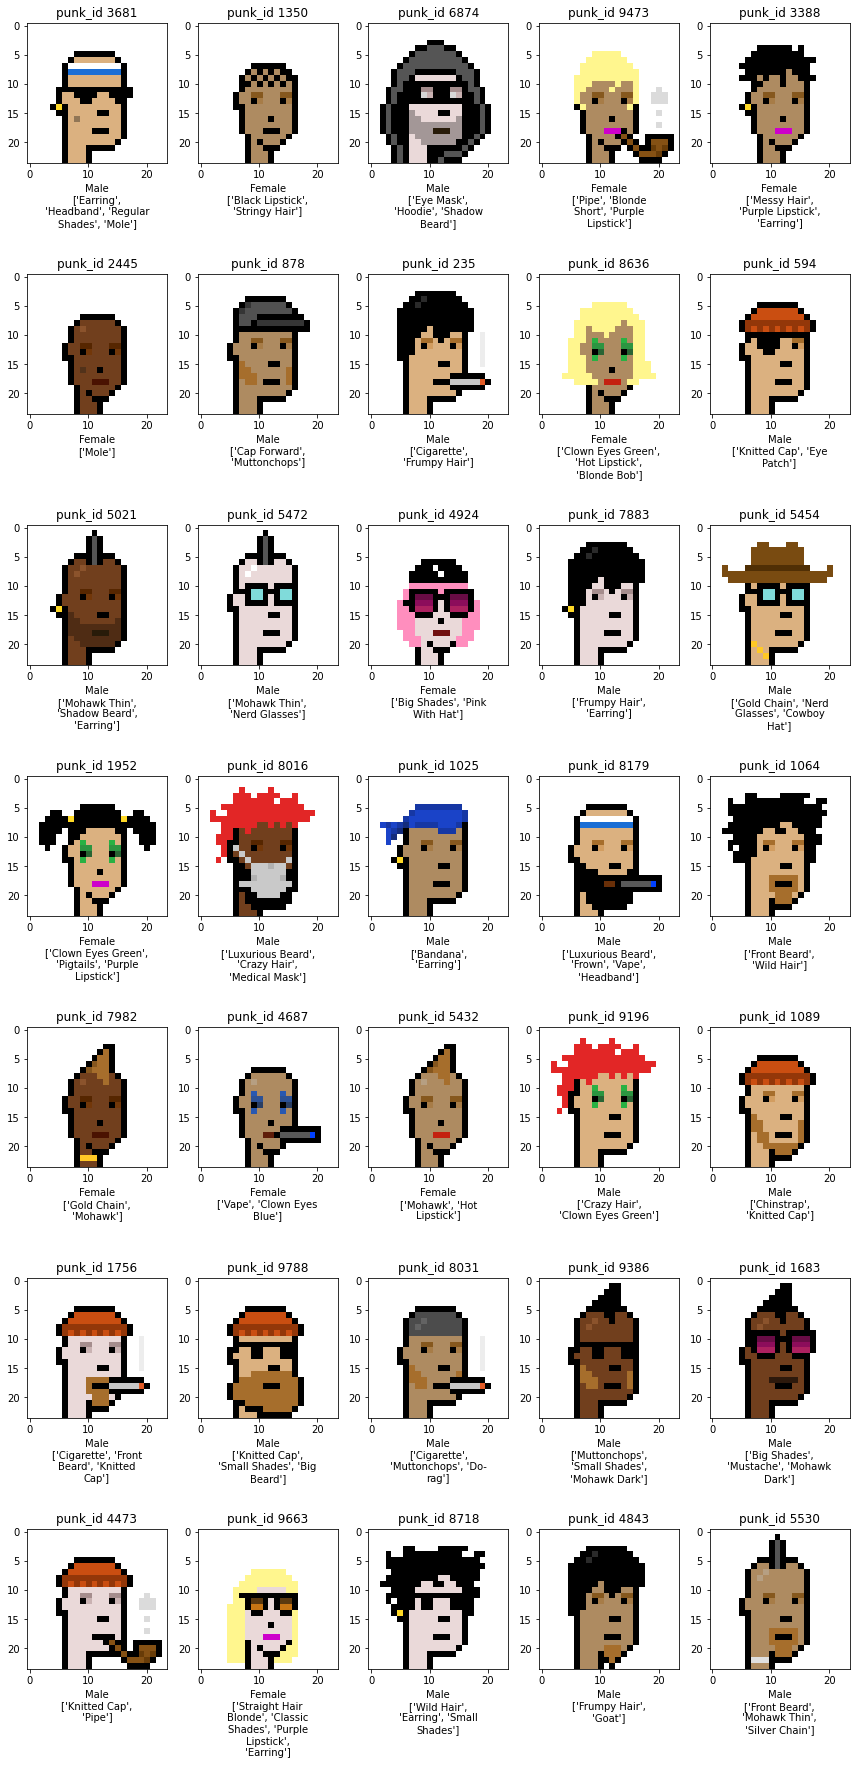

In [11]:
# Inspect a random set of 35 images in a 5 by 7 grid to better
# understand type and accessory features

# create plot
plt.figure(0, figsize=(12,25))

# Initialize variables
cpt = 0
pic_size = 24

# Loop for each row to plot
for n in range(7):

    # Loop for each column to plot
    for i in range(1,6):
        cpt=cpt + 1
        plt.subplot(7,5,cpt)
        
        # Select a random punk image and add it to the plot
        id = random.randint(0,9999)
        file_to_load = ("images/"+str(id)+".png")
        punk_image = Image.open(file_to_load)
        plt.imshow(punk_image)
        plt.title("punk_id "+str(id))
        punk_type = crypto_punks_df.loc[crypto_punks_df["punk_id"] == id,"type"].iloc[0]
        punk_accessories = crypto_punks_df.loc[crypto_punks_df["punk_id"] == id,"accessories"].iloc[0]
        wrapped_label = punk_type+"\n"+("\n".join(wrap(punk_accessories,20)))
        plt.xlabel(wrapped_label)
        
# Show the plotted images   
plt.tight_layout()
plt.show

## Create a Data Table for Cataloging the Unique Accessories

In [12]:
# Create a list of the individual accessories
# Capture all individual types and accessories and store them in list

# Create an empty list to hold the data
accessories_list =[]

# Loop through the dataframe
for row in range(len(df)):

    # Add a new field with the count of accessories
    accessory_count = len(df.at[row,"accessories"])
    df.at[row,"accessory_count"]=accessory_count
    
    # Add each new accessory description to a list of unique values
    for i in df.at[row,"accessories"]:
        
        if i not in accessories_list:
            accessories_list.append(i)

# Print all the unique accessories
print("There are "+str(len(accessories_list))+" distinct accessories:")
print(accessories_list)

There are 87 distinct accessories:
['Green Eye Shadow', 'Earring', 'Blonde Bob', 'Smile', 'Mohawk', 'Wild Hair', 'Nerd Glasses', 'Pipe', 'Big Shades', 'Goat', 'Purple Eye Shadow', 'Half Shaved', 'Do-rag', 'Wild White Hair', 'Spots', 'Clown Eyes Blue', 'Messy Hair', 'Luxurious Beard', 'Clown Nose', 'Police Cap', 'Big Beard', 'Blue Eye Shadow', 'Black Lipstick', 'Clown Eyes Green', 'Straight Hair Dark', 'Blonde Short', 'Purple Lipstick', 'Straight Hair Blonde', 'Pilot Helmet', 'Hot Lipstick', 'Regular Shades', 'Stringy Hair', 'Small Shades', 'Frown', 'Eye Mask', 'Muttonchops', 'Bandana', 'Horned Rim Glasses', 'Crazy Hair', 'Classic Shades', 'Handlebars', 'Mohawk Dark', 'Dark Hair', 'Peak Spike', 'Normal Beard Black', 'Cap', 'VR', 'Frumpy Hair', 'Cigarette', 'Normal Beard', 'Red Mohawk', 'Shaved Head', 'Chinstrap', 'Mole', 'Knitted Cap', 'Fedora', 'Shadow Beard', 'Straight Hair', 'Hoodie', 'Eye Patch', 'Headband', 'Cowboy Hat', 'Tassle Hat', '3D Glasses', 'Mustache', 'Vape', 'Choker', 'Pi

In [13]:
# Create a dataframe from the list
accessories_df = pd.DataFrame(accessories_list)
accessories_df

,0
0,Green Eye Shadow
1,Earring
2,Blonde Bob
3,Smile
4,Mohawk
...,...
82,Orange Side
83,Wild Blonde
84,Buck Teeth
85,Top Hat


In [14]:
# Assign a header name to the first column
accessories_df.rename(columns={0: "accessory"}, inplace=True)
accessories_df

,accessory
0,Green Eye Shadow
1,Earring
2,Blonde Bob
3,Smile
4,Mohawk
...,...
82,Orange Side
83,Wild Blonde
84,Buck Teeth
85,Top Hat


In [15]:
# Add a new column for count and initialize it to zero
for row in range(len(accessories_df)):
    accessories_df["counts"]=0
    
accessories_df

,accessory,counts
0,Green Eye Shadow,0
1,Earring,0
2,Blonde Bob,0
3,Smile,0
4,Mohawk,0
...,...,...
82,Orange Side,0
83,Wild Blonde,0
84,Buck Teeth,0
85,Top Hat,0


In [16]:
# Loop through the crypto punk id's to establish a count of 
# how often each accessory appears.    
for row in range(len(crypto_punks_df)):

    # read the string of individual accessories
    individual_accessory = crypto_punks_df.at[row,"accessories"]
    
    # clean the string by removing special characters
    characters_to_remove="[']"
    for character in characters_to_remove:
        individual_accessory = individual_accessory.replace(character, "")
    
    # convert the string back to a list
    individual_list = list(individual_accessory.split(", "))
    
    # loop through the individual accessories associated with the punk_id
    for accessory in individual_list:
        
        # look for the index of the accessory in the accessories_df and add to the count
        accessory_index = accessories_df.index[accessories_df['accessory']==accessory]
        accessories_df.at[accessory_index,'counts']=accessories_df.loc[accessory_index,'counts']+1
        
accessories_df

,accessory,counts
0,Green Eye Shadow,271
1,Earring,2459
2,Blonde Bob,147
3,Smile,238
4,Mohawk,441
...,...,...
82,Orange Side,68
83,Wild Blonde,144
84,Buck Teeth,78
85,Top Hat,115


In [17]:
# Sort the counts in descending order
sorted_accessories_df = accessories_df.sort_values(['counts'], ascending=False)
sorted_accessories_df.head(50)

,accessory,counts
1,Earring,2459
48,Cigarette,961
29,Hot Lipstick,696
26,Purple Lipstick,655
53,Mole,644
22,Black Lipstick,617
6,Nerd Glasses,572
37,Horned Rim Glasses,535
8,Big Shades,535
30,Regular Shades,527


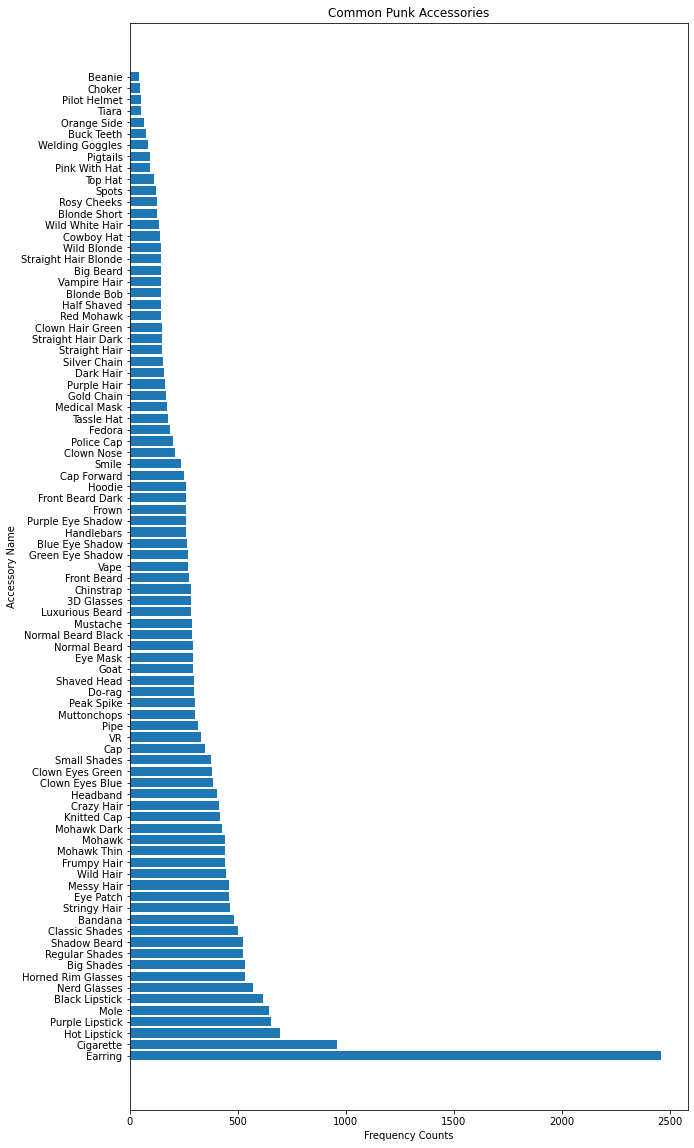

In [18]:
# Plot the frequency of the accessories counts
fig = plt.figure(figsize=(10,20))
plt.barh(sorted_accessories_df['accessory'], sorted_accessories_df['counts'])
plt.title('Common Punk Accessories')
plt.xlabel('Frequency Counts')
plt.ylabel('Accessory Name')
plt.show()

In [19]:
# Export the sorted_accessories_df as a csv for further grouping
# analysis using excel
sorted_accessories_df.to_csv(r"Data/sorted_accessories.csv", index = False)

## Group the Accessories

In [20]:
# After analyzing the data in excel, the accessories were grouped
# into 7 classes: Accessories, Beard, Eyes-Glasses, Hair, Headgear, 
# Mouth and Other.

# Read the csv with the class groupings and convert it to a new
# dataframe
categorized_accessories_df = pd.read_csv("Data/Accessories_class.csv")
categorized_accessories_df

,accessory,counts,class_group1,class_group2,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,3D Glasses,286,Eyes-Glasses,Eyes-Glasses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bandana,481,Headgear,Headgear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Beanie,44,Headgear,Headgear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Big Beard,146,Beard,Beard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Big Shades,535,Eyes-Glasses,Eyes-Glasses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Welding Goggles,86,Eyes-Glasses,Eyes-Glasses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,Wild Blonde,144,Hair,Hair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,Wild Hair,447,Hair,Hair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,Wild White Hair,136,Hair,Hair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Drop the un-needed columns from the excel csv.
categorized_accessories_df = categorized_accessories_df.dropna(axis=1)
categorized_accessories_df

,accessory,counts,class_group1,class_group2
0,3D Glasses,286,Eyes-Glasses,Eyes-Glasses
1,Bandana,481,Headgear,Headgear
2,Beanie,44,Headgear,Headgear
3,Big Beard,146,Beard,Beard
4,Big Shades,535,Eyes-Glasses,Eyes-Glasses
...,...,...,...,...
82,Welding Goggles,86,Eyes-Glasses,Eyes-Glasses
83,Wild Blonde,144,Hair,Hair
84,Wild Hair,447,Hair,Hair
85,Wild White Hair,136,Hair,Hair


In [22]:
# Inspect the two class groupings
categorized_accessories_df.groupby(["class_group1"], as_index=False)["counts"].sum()

,class_group1,counts
0,Accessories,5709
1,Beard,3052
2,Eyes-Glasses,5740
3,Hair,6290
4,Headgear,2936
5,Mouth,2046
6,Other,1766


In [23]:
categorized_accessories_df.groupby(["class_group2"], as_index=False)["counts"].sum()

,class_group2,counts
0,Accessories,4769
1,Beard,3650
2,Eyes-Glasses,6072
3,Hair,6175
4,Headgear,3364
5,Mouth,2046
6,Other,1463


## Decide on the Target Data 

In [24]:
#####################################################################
##
##  Based on the distribution of "Type" and "Accessories" field 
##  values we decided on two options for our target data:
##
##     Option 1: predict the "type", from either "Male", "Female" or 
##               "Other", where "Other" groups "Zombie", "Ape" and
##               "Alien" types.
##
##     Option 2: predict whether the image has glasses, where the
##               "accessories" field includes any of the values
##               "3D Glasses", "Big Shades", "Classic Shades", 
##               "Eye Mask", Horned Rim Glasses", "Nerd Glasses", 
##               "Regular Shades", "Small Shades", "VR" or "Welding 
##               Goggles".
##
#####################################################################

In [25]:
# Create a list for the glasses accessories
glasses = ["3D Glasses", 
           "Big Shades", 
           "Classic Shades",
           "Eye Mask",
           "Horned Rim Glasses",
           "Nerd Glasses", 
           "Regular Shades", 
           "Small Shades", 
           "VR",
           "Welding Goggles"]

In [26]:
# Inspect the data types again
crypto_punks_df.dtypes

punk_id        object
type           object
accessories    object
dtype: object

In [27]:
# Loop through the crypto_punks_df dataframe and
# assign values to the target fields

for row in range(len(crypto_punks_df)):
    
    # In a new columnt, "type_ML", assign a numerical value to
    # the type: set Male = 0, Female = 1 and 
    # Other(Zombie/Ape/Alien) = 2
    
    if crypto_punks_df.loc[row,"type"] == "Male":
        crypto_punks_df.loc[row,"type_ML"] = 0
    elif crypto_punks_df.loc[row,"type"] == "Female":
        crypto_punks_df.loc[row,"type_ML"] = 1
    else:
        crypto_punks_df.loc[row,"type_ML"] = 2

    # Determine if the accessories include any glasses
    # 1. Get the accessories for the given punk_id
    punk_accessories = crypto_punks_df.loc[row,"accessories"]
    
    # 2. Assign a value of 0 to a new column names "glasses_ML"
    #    to indicate the punk_id currently has no glasses
    crypto_punks_df.loc[row,"glasses_ML"] = 0
    
    # 2. Loop trough the list of possible glasses
    for glass in glasses:
        
        # 3. If already found glasses, stop checking
        if (crypto_punks_df.loc[row,"glasses_ML"] == 0):
        
            # 4. if the accessories include any of the glasses
            #    indicate a 1 in the column "glasses_ML"
            if glass in punk_accessories:
                crypto_punks_df.loc[row,"glasses_ML"] = 1
            
crypto_punks_df.head(5)

/Users/ignacioguerra/Desktop/DATA BOOTCAMP CODING/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/ignacioguerra/Desktop/DATA BOOTCAMP CODING/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,punk_id,type,accessories,type_ML,glasses_ML
0,0,Female,"['Green Eye Shadow', 'Earring', 'Blonde Bob']",1.0,0.0
1,1,Male,"['Smile', 'Mohawk']",0.0,0.0
2,2,Female,['Wild Hair'],1.0,0.0
3,3,Male,"['Wild Hair', 'Nerd Glasses', 'Pipe']",0.0,1.0
4,4,Male,"['Big Shades', 'Wild Hair', 'Earring', 'Goat']",0.0,1.0


In [28]:
# Inspect the crypto_punks_df by "type_ML"
crypto_punks_df.groupby(["type_ML"], as_index=False)["punk_id"].count()

,type_ML,punk_id
0,0.0,6039
1,1.0,3840
2,2.0,121


In [29]:
# Inspect the crypto_punks_df by "glasses_ML"
crypto_punks_df.groupby(["glasses_ML"], as_index=False)["punk_id"].count()

,glasses_ML,punk_id
0,0.0,5954
1,1.0,4046


In [30]:
# Create a list for the target type classifications
type_classification = ["Male","Female","Other"]

# Create a list for the target glasses classification
glasses_classification = ["No Glasses", "Has Glasses"]

## Inspect the Shape of a Random Bit Map Array

In [31]:
id = random.randint(0,9999)

# set the fillename based on that id
file_to_open = ("images/"+str(id)+".png")
    
# Read the RGB image for that id
rgb_image = Image.open(file_to_open)

# Convert the image to a bit array
rgb_bit_map = np.asarray(rgb_image)

# Inspect the shape of the array
rgb_bit_map.shape

(24, 24, 4)

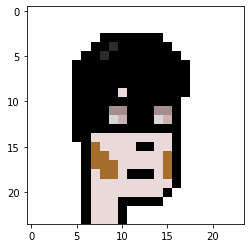

In [32]:
# Plot the RGB image
img = plt.imshow(rgb_bit_map)

In [33]:
# Create a new dataframe to store the bitmaps
#bitmap_df = pd.DataFrame(columns=[1])

# Change the data type to object so that Pandas can accept
# storing the array in a field
#bitmap_df[1] = bitmap_df[1].astype(object)

# store the normalized bit map array
#bitmap_df.loc[0,1] = rgb_bit_map/255

#
#bitmap_df

## Add Image Bit Map Array for each Punk_ID

In [34]:
######################################################################
# Loop through the punk_ids, search for the corresponding image file, 
# convert the file to a bit map array, and store the array as a new 
# field in the crypto_punks_df
######################################################################

In [35]:
# Create a new dataframe to store the bitmaps
bitmap_df = pd.DataFrame(columns=[1,2])

# Change the data type to object so that Pandas can accept
# storing the array in a field
bitmap_df[1] = bitmap_df[1].astype(object)
bitmap_df[2] = bitmap_df[2].astype(object)

bitmap_df.dtypes

1    object
2    object
dtype: object

In [36]:
print(len(crypto_punks_df))

10000


In [37]:
# Loop through the crypto punk IDs
for row in range(10000):
    
    # read the id for each crypto punk
    id = (crypto_punks_df.loc[row,"punk_id"])
    
    # set the fillename based on that id
    file_to_open = ("images/"+str(id)+".png")
    
    # Read the RGB image for that id
    rgb_image = Image.open(file_to_open)
    
    # Convert the image to a bitmap array
    rgb_bit_map = np.asarray(rgb_image)
    
    # Store the image bitmap into the bitmap_df
    bitmap_df.loc[row,2] = rgb_bit_map
    
    # Normalize the bitmap array for use by the Machine Learning model
    norm_rgb_bit_map = rgb_bit_map / 255
    
    # Store the normalized array into the bitmap_df
    bitmap_df.loc[row,1] = norm_rgb_bit_map

# Assign a proper header name to the first column
bitmap_df.rename(columns={1: "normalized_bitmap",2:"image_bitmap"}, inplace=True)
bitmap_df

,normalized_bitmap,image_bitmap
0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
1,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
2,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
3,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
4,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
...,...,...
9995,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
9996,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
9997,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
9998,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."


In [38]:
# Join the crypto_punks_df with the bitmap_df to create a new 
# machine_learning_df
machine_learning_df = crypto_punks_df.join(bitmap_df)
machine_learning_df

,punk_id,type,accessories,type_ML,glasses_ML,normalized_bitmap,image_bitmap
0,0,Female,"['Green Eye Shadow', 'Earring', 'Blonde Bob']",1.0,0.0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
1,1,Male,"['Smile', 'Mohawk']",0.0,0.0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
2,2,Female,['Wild Hair'],1.0,0.0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
3,3,Male,"['Wild Hair', 'Nerd Glasses', 'Pipe']",0.0,1.0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
4,4,Male,"['Big Shades', 'Wild Hair', 'Earring', 'Goat']",0.0,1.0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
...,...,...,...,...,...,...,...
9995,9995,Female,"['Purple Eye Shadow', 'Straight Hair Dark']",1.0,0.0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
9996,9996,Male,"['Cigarette', 'Earring', 'Crazy Hair', 'Smile']",0.0,0.0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
9997,9997,Zombie,"['Front Beard', 'Cap Forward']",2.0,0.0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
9998,9998,Female,"['Wild White Hair', 'Black Lipstick', 'Clown E...",1.0,0.0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."


## ALICIA/GABRIELA: FINALMENTE CREO QUE TENEMOS LA DATA PARA CARGAR AL MODELO DE ML.

## DE LA TABLA DE ARRIBA, machine_learning_df, USARIAMOS COMO X LA DATA QUE ESTA EN LA COLUMNA normalized_bitmap Y USARIAMOS COMO Y:

## * type_ML SI QUEREMOS PREDECIR EL TIPO, O 

## * glasses_ML SI QUEREMOS PREDECIR SI LLEVA LENTES O NO.


## TAMBIEN DEBEMOS REVISAR LOS DEPENDENCIES. NO CREO QUE NECESITEMOS LOS SIGUIENTES:
## * os
## * sqlite3
## * requests
## * pymongo
## * seaborn (a menos que luego querramos graficar algo)